In [72]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.metrics import r2_score

In [73]:
df = pd.read_csv('../data/flights_dataset.csv')
df = df.drop(df.columns[0], axis=1)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [75]:
# Price is in Indian rupees, let us convert it to usd

df['price'] = df['price'].div(83).round(2)

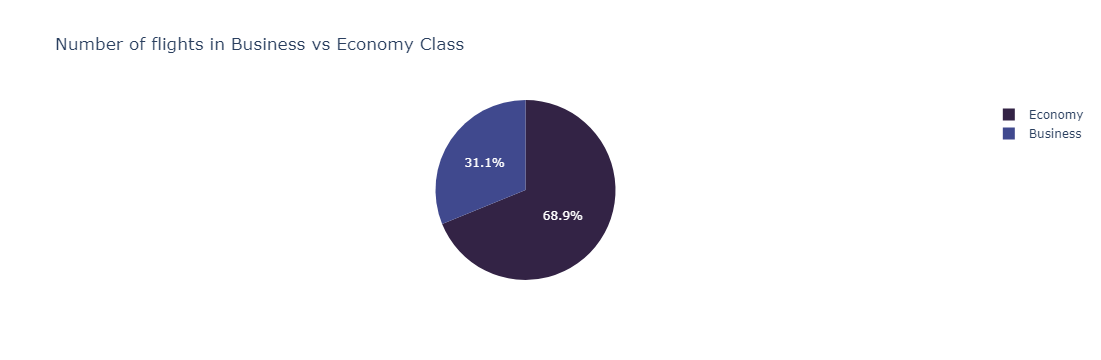

In [76]:
class_counts = df['class'].value_counts()

# Define colors
colors = ['#332345', '#40498e']

# Create a Pie chart
fig = go.Figure(data=[go.Pie(labels=class_counts.index, 
                             values=class_counts.values,
                             marker=dict(colors=colors),
                             textinfo='percent',
                             textposition='inside'
                            )
                     ])

# Update layout
fig.update_layout(title="Number of flights in Business vs Economy Class")

# Display the plot
fig.show()

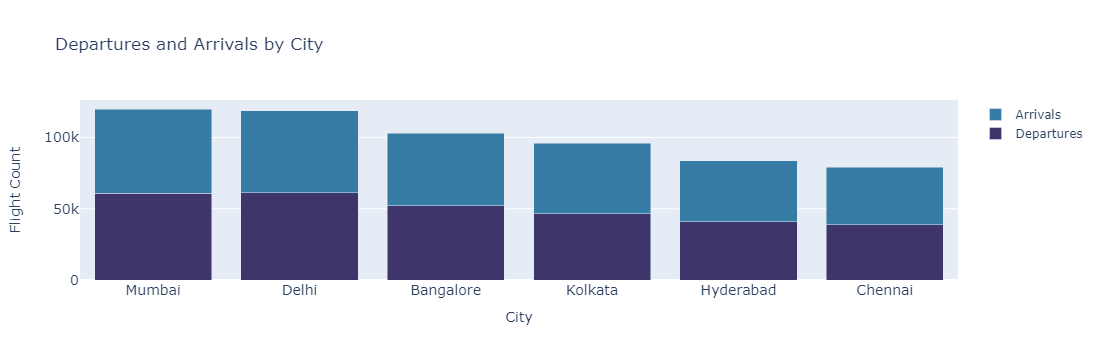

In [77]:
departure_counts = df['source_city'].value_counts()
arrival_counts = df['destination_city'].value_counts()

# Concatenate counts
city_counts = pd.concat([departure_counts, arrival_counts], axis=1, keys=['Departures', 'Arrivals'])

# Calculate total counts
city_counts['Total'] = city_counts['Departures'] + city_counts['Arrivals']

# Sort by total counts
city_counts.sort_values(by='Total', ascending=False, inplace=True)

# Create traces
trace1 = go.Bar(x=city_counts.index, y=city_counts['Departures'], name='Departures', marker=dict(color='#3e356b'))
trace2 = go.Bar(x=city_counts.index, y=city_counts['Arrivals'], name='Arrivals', marker=dict(color='#357ba3'))

# Create a stacked bar chart
fig = go.Figure(data=[trace1, trace2])

# Update layout
fig.update_layout(barmode='stack',
                  title='Departures and Arrivals by City',
                  xaxis=dict(title='City', tickfont=dict(size=14)),
                  yaxis=dict(title='Flight Count', tickfont=dict(size=14)),
                  legend=dict(font=dict(size=12))
                 )

# Display the plot
fig.show()

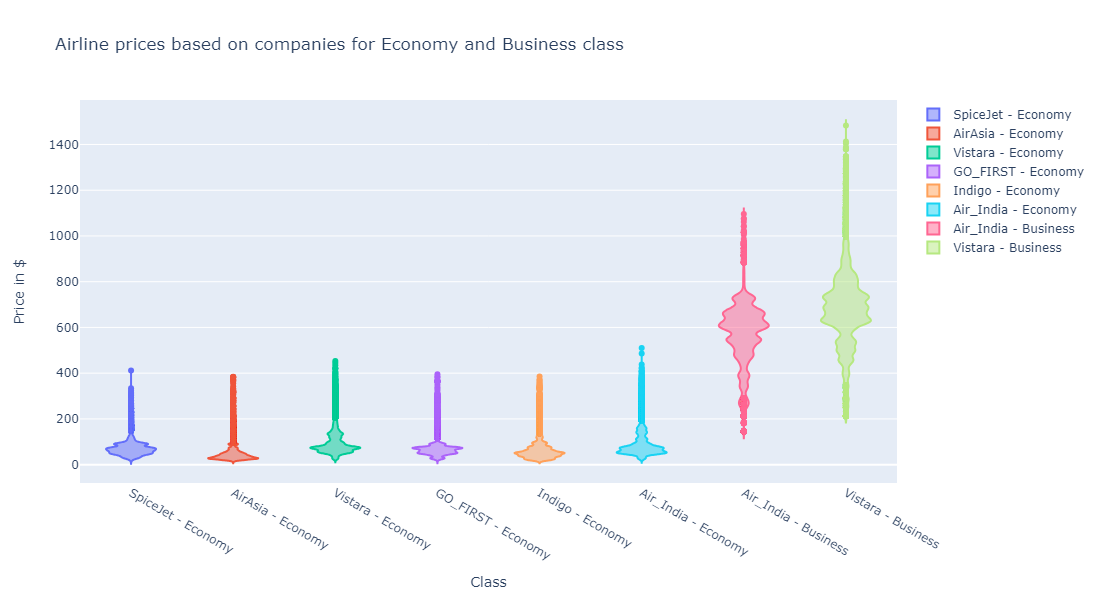

In [79]:
fig = go.Figure()

# Economy Class Violin Plots
economy_airlines = df[df["class"] == 'Economy']["airline"].unique()
for airline in economy_airlines:
    economy_data = df[(df["class"] == 'Economy') & (df["airline"] == airline)]
    fig.add_trace(go.Violin(y=economy_data["price"], name=f'{airline} - Economy'))

# Business Class Violin Plots
business_airlines = df[df["class"] == 'Business']["airline"].unique()
for airline in business_airlines:
    business_data = df[(df["class"] == 'Business') & (df["airline"] == airline)]
    fig.add_trace(go.Violin(y=business_data["price"], name=f'{airline} - Business'))

# Update layout
fig.update_layout(title="Airline prices based on companies for Economy and Business class",
                  xaxis=dict(title='Class'),
                  yaxis=dict(title='Price in $'),
                  height=600,  # Adjust height here
                  width=800)

# Display the plot
fig.show()

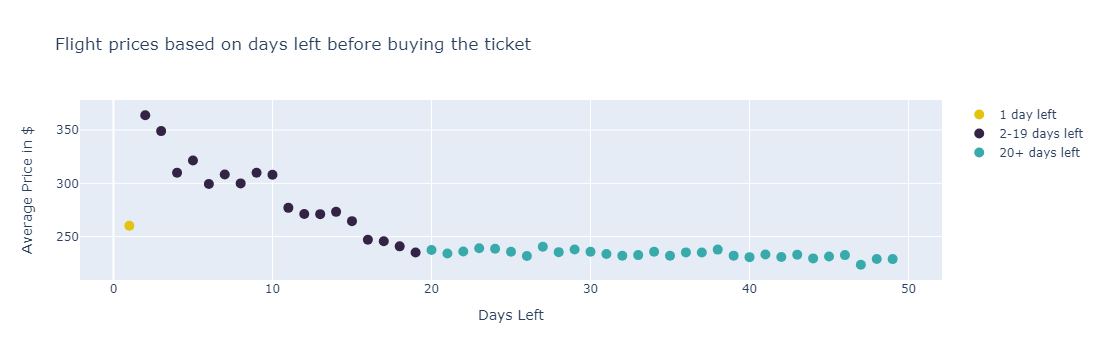

In [16]:
price_by_day = df.groupby(['days_left'])['price'].mean().reset_index()

# Create traces for each category of days left
trace1 = go.Scatter(x=price_by_day[price_by_day['days_left'] == 1]['days_left'],
                    y=price_by_day[price_by_day['days_left'] == 1]['price'],
                    mode='markers',
                    name='1 day left',
                    marker=dict(color='#e3c310', size=10)
                   )
trace2 = go.Scatter(x=price_by_day[(price_by_day['days_left'] > 1) & (price_by_day['days_left'] < 20)]['days_left'],
                    y=price_by_day[(price_by_day['days_left'] > 1) & (price_by_day['days_left'] < 20)]['price'],
                    mode='markers',
                    name='2-19 days left',
                    marker=dict(color='#332345', size=10)
                   )
trace3 = go.Scatter(x=price_by_day[price_by_day['days_left'] >= 20]['days_left'],
                    y=price_by_day[price_by_day['days_left'] >= 20]['price'],
                    mode='markers',
                    name='20+ days left',
                    marker=dict(color='#38aaac', size=10)
                   )

# Combine traces into data list
data = [trace1, trace2, trace3]

# Create layout
layout = go.Layout(title='Flight prices based on days left before buying the ticket',
                   xaxis=dict(title='Days Left'),
                   yaxis=dict(title='Average Price in $'),
                   hovermode='closest',
                   showlegend=True
                  )

# Create figure
fig = go.Figure(data=data, layout=layout)

# Display the plot
fig.show()

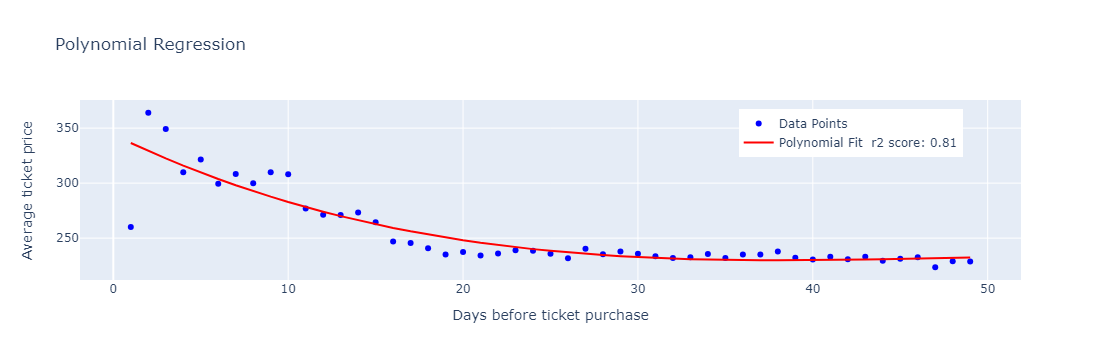

In [19]:
# Fit polynomial regression
x = price_by_day['days_left']
y = price_by_day['price']
coefficients = np.polyfit(x, y, 3)
poly = np.poly1d(coefficients)
y_fit = poly(x)
mse = r2_score(y, y_fit)

# Create traces
trace_data = go.Scatter(x=x, y=y, mode='markers', name='Data Points', marker=dict(color='blue'))
trace_fit = go.Scatter(x=x, y=y_fit, mode='lines', name=f'Polynomial Fit \nr2 score: {mse:.2f}', line=dict(color='red'))

# Combine traces into data list
data = [trace_data, trace_fit]

# Create layout
layout = go.Layout(title='Polynomial Regression',
                   xaxis=dict(title='Days before ticket purchase'),
                   yaxis=dict(title='Average ticket price'),
                   legend=dict(x=0.7, y=0.95)
                  )

# Create figure
fig = go.Figure(data=data, layout=layout)

# Display the plot
fig.show()

In [20]:
lat_long = {
    'Mumbai': [19.076090, 72.877426],
    'Delhi': [28.679079, 77.069710],
    'Bangalore': [12.971599, 77.5946],
    'Kolkata': [22.5726, 88.3639],
    'Hyderabad': [17.4065, 78.4772],
    'Chennai': [13.0827, 80.2707]
}



In [24]:
df['from_latitude'] = df['source_city'].map(lambda x: lat_long.get(x)[0])
df['from_longitude'] = df['source_city'].map(lambda x: lat_long.get(x)[1])
df['to_latitude'] = df['destination_city'].map(lambda x: lat_long.get(x)[0])
df['to_longitude'] = df['destination_city'].map(lambda x: lat_long.get(x)[1])

# Group by source and destination cities
grouped_flights = df.groupby(['source_city', 'destination_city']).size().reset_index(name='count')

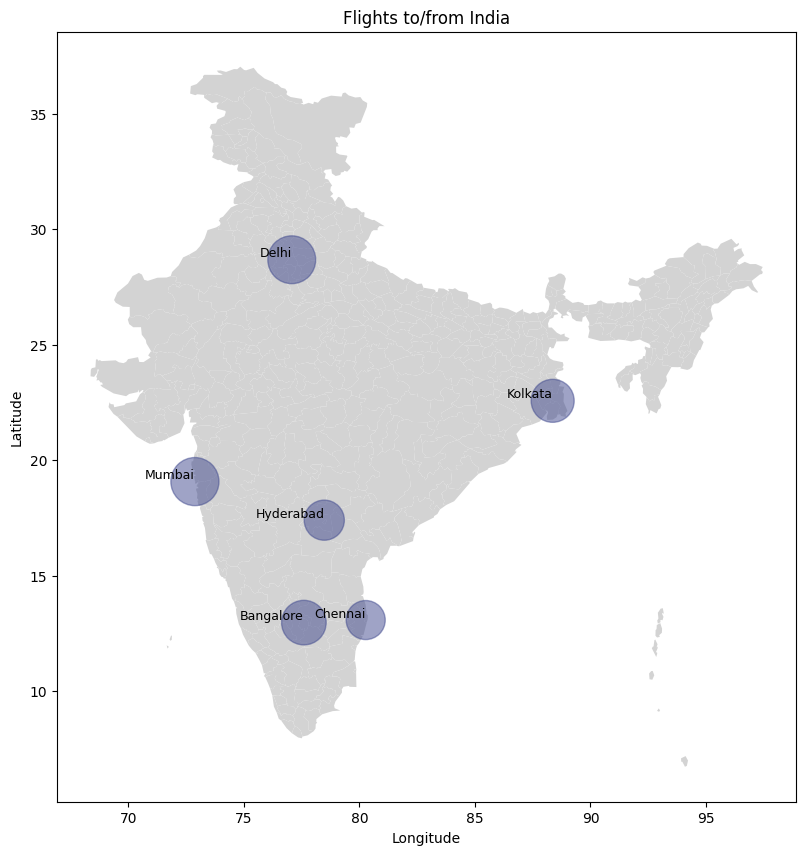

In [45]:
import mplcursors
import geopandas as gpd

# Load India shapefile
india = gpd.read_file("../shape/india_ds.shp")

longitudes = []
latitudes = []
city_names = []

for city, coords in lat_long.items():
    city_names.append(city)
    latitudes.append(coords[0])
    longitudes.append(coords[1])
    
# Load India shapefile
india = gpd.read_file("../shape/india_ds.shp")

# Plot India map
fig, ax = plt.subplots(figsize=(10,10))
india.plot(ax=ax, color='lightgrey')

# Plot flights on the map
scatter = plt.scatter(longitudes,latitudes, color='#40498e', s=[count/100 for count in city_counts['Total'].tolist()], alpha=0.5, label='Flights to/from India')

for i, city in enumerate(city_names):
    plt.text(longitudes[i], latitudes[i], city, fontsize=9, ha='right', va='bottom')

mplcursors.cursor(scatter, hover=True).connect("add", lambda sel: sel.annotation.set_text(df['Total'].iloc[sel.target.index]))

plt.title('Flights to/from India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

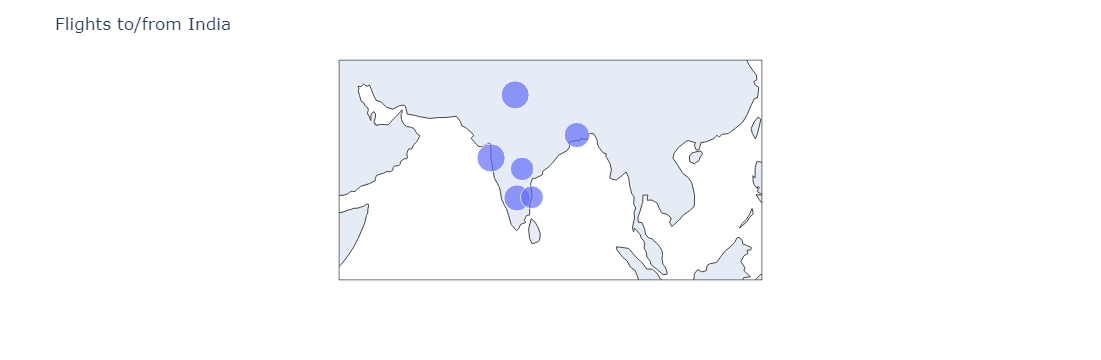

In [24]:
import plotly.express as px
import pandas as pd

# Assuming df contains the city information
df = pd.DataFrame({
    'City': city_names,
    'Latitude': latitudes,
    'Longitude': longitudes,
    'Total flights count': [count/100 for count in city_counts['Total'].tolist()]
})

fig = px.scatter_geo(df, lat='Latitude', lon='Longitude', hover_name='City', size='Total flights count')
fig.update_geos(projection_type="natural earth")
fig.update_layout(title='Flights to/from India')

fig.show()